#### Report food 📚🐲 -- Se Question ❓

This script takes a closer look at the assessment file. It aims to get more information about the dataset as a whole and decide if the dropping of the duplicate columns should be done consciously or just keeping the first one.

The data set is a collection of wave files containing the pronunciation of different words spoken by native and non-native-speaking children. With each wave file, the pronunciation of the word is assessed. The assessment was done by two assessors who are native speakers. The assessors gave each file a score between 0 and 5 based on the pronunciation of the word analysed on each phone. The data set contains the following columns of information: 'File name', 'Score', 'Prosody', 'Noise/Disruption', 'Pre-speech noise', 'Repetition', 'Word', 'Pronunciation', 'pronScores', 'Assessor'. The 'File name' contains the speaker ID and whether or not the speaker is native. In some wave files, we also find the repetition of the word or the child asking questions; this can affect the results when using machine learning; therefore, files with the score 0 m are removed. 

In machine learning, the result will always depend on the quality of the data that is put in. In this case, it means removing the files with the score 0, meaning they don't pronoun the word. Both assessors also do the assessments, so the duplicate data is also removed.


<span style="color:#E70000"> NB!❓</span> 

* ❓ When removing duplicates, files are removed without seeing if they have the same assessment. Should this be checked out more thoroughly 
* Is the data balanced? How many of each score? The native data is almost uniformly distributed, but the non-native data has 67% with a score of 5.
* How many of each speaker? Of the used data frame, 67% are native speakers, and 33% are non-native speakers.

Information about the Assessment file:

We find 2821 duplicates in the File names; this means bot assessors have assessed the same file. 
We also find one instance where bot assessors have assessed this file twice (4 assessments), but all columns are the same.
For the rest, most of them are 1 group of 2 assessments. These are entirely similar, different for pronScores and score, or all the columns are the same except the score is different. The two last cases are something that should be taken into account before removing duplicates. How it is dealt with now is that the first instance is kept, and the rest is removed. 

theory related to this section
* What is a Phone
* How Children pronauntiate words
* How non-native children / people pronatuate words differently

In [44]:
# Load dataset before analysing the assesment file setup
import self_made_functions as smf
from prettytable import PrettyTable
import pandas as pd 
import numpy as np
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

data_path = '/talebase/data/speech_raw/teflon_no/'
wv_path = data_path + 'speech16khz/'

# Data frame fixing -------------
df_assessment = pd.read_csv(data_path + 'assessments.csv') # Loade file
df_new_no_zero = df_assessment[df_assessment['Score'] != 0] # Remove Zero scores
df_all_zeros = df_assessment[df_assessment['Score'] == 0] # Get all zero scores

# Get the index of the max score for each file name group
max_score_indices = df_new_no_zero.groupby('File name')['Score'].idxmax() 
df_no_dup = df_new_no_zero.loc[max_score_indices]

# Get the mean score for each file name group
mean_scores = df_new_no_zero.groupby('File name')['Score'].mean().apply(np.ceil).astype(int)

# Replace the 'Score' column with the rounded mean scores
df_no_dup['Score'] = df_no_dup['File name'].map(mean_scores)
df_no_dup.reset_index(drop=True, inplace=True)    

In [45]:
# Report food 📚🐲
table_df_info = PrettyTable()
table_df_info.field_names = ['Description', 'Value [# samples]', 'Status']
# table_df_info.align['Description'] = 'l'
# table_df_info.align['Value'] = 'r'
# table_df_info.align['Status'] = 'l'

# Data frame sample information
table_df_info.add_row(['Length of the original data frame', len(df_assessment),''])
table_df_info.add_row(['Numbers of duplicates', (len(df_assessment)-len(df_no_dup)+len(df_all_zeros)), 'Removed'])
table_df_info.add_row(['Numbers of files with score zeros', len(df_all_zeros), 'Removed'])
table_df_info.add_row(['Length of the data finished data frame', len(df_no_dup),'Samples used in analysis'])
table_df_info.add_row(['Number of unique words', len(df_no_dup['Word'].unique()), ''])

children = smf.get_unique_speakers(df_no_dup)
children = len(children)
table_df_info.add_row(['Number of different children', children, ''])


table_df_info.add_row(['','',''])
# Number of native and non-native speakers
non_native = df_no_dup[df_no_dup['File name'].str.startswith(('a'))]
native = df_no_dup[df_no_dup['File name'].str.startswith(('d'))]
def calculate_percentage(subset_count, total_count): return (subset_count / total_count) * 100

# Score distribution
def calculate_score_percentage(df, table, who): 
    total = 0
    table.add_row([f'Mean score for {who}', '', round(df['Score'].mean(), 1)])
    for i in range(1,6):
        score = len(df[df['Score'] == i])
        table.add_row([f'Score {i} for {who}', score, f'{calculate_percentage(score, len(df)):1.1f} %'])
        total += score
    print(f'total {who} :', total)


table_df_info.add_row(['Numbers of native speakers', len(native), f'{calculate_percentage(len(native), len(df_no_dup)):1.1f} % of data set'])
calculate_score_percentage(native, table_df_info, 'native')
table_df_info.add_row(['','',''])

table_df_info.add_row(['Numbers of non-native speakers', len(non_native),f'{calculate_percentage(len(non_native), len(df_no_dup)):1.1f} % of data set'])
calculate_score_percentage(non_native, table_df_info, 'non_native')

print(table_df_info)
print('Assesment file columns: ', df_assessment.columns.tolist())

total native : 3096
total non_native : 6226
+----------------------------------------+-------------------+--------------------------+
|              Description               | Value [# samples] |          Status          |
+----------------------------------------+-------------------+--------------------------+
|   Length of the original data frame    |       12264       |                          |
|         Numbers of duplicates          |        3109       |         Removed          |
|   Numbers of files with score zeros    |        167        |         Removed          |
| Length of the data finished data frame |        9322       | Samples used in analysis |
|         Number of unique words         |        205        |                          |
|      Number of different children      |         52        |                          |
|                                        |                   |                          |
|       Numbers of native speakers       |        3096  

##### Check how the duplicate data correlates
For some off the duplicates the 'pronScores' or 'Score' are different. To handle this I will remove the duplicates with the <span style="color:#E70000"><b>lowest</b><span> score. This is more motevating results if used in a game setting. 

When analyzing the data it excists two occurences where the whole row is a duplicate. Looking at the 'File name' column it is found 2821 duplicates. The duplicates are removed with the pandas drop_duplicates('File name'). This keeps the first occurance of the file name. It does not take into account if the assessors might have given the data different scores.  

<b> It is found that 696 of the files have different scores given by the assessors. </b>

Most of them have different 'pronScores', but same score, BUT, some of them is everything the same except the score like 'a01_glass.wav'. (205 files are like that)

In [46]:
# Check how the duplicate data correlates
# Find the dup columns
duplicates = df_assessment[df_assessment.duplicated('File name', keep=False)]

duplicates = duplicates.drop(columns='Assessor') # Drop the assessor column, cause the interesting part is the other columns
head_name = df_assessment.columns.tolist() # column names
dup_group = duplicates.groupby('File name') # Group the duplicates by file names
# print(type(dup_group))c 

dup_diff_row = [] # save the row where the columns differ
dup_diff_only_score = [] # save the rows where the only difference is the score
number_of_similar_assessments = 0

# Goes through all the duplicates - Function made by help from ChatGPT
for name, group in dup_group:
    group = group.drop(columns='File name') # Drops the file name column since we know this is the same
    
    # nunique() returns the number of unique elements in the different columns
    if group.nunique().max() == 1: # Check if all columns are the same
        # print(f"All columns are the same for rows with 'File name' {name}")
        number_of_similar_assessments += 1
    else: # Some of the columns are different
        # print(f"Columns differ for rows with 'File name' {name}")
        # print(f"The columns that differ are: {diff}")
        diff = group.columns[group.nunique() > 1].tolist() # get the name of the columns that are different
        dup_diff_row.append([name, diff])
        if ['Score'] == diff:
            # print(f'Score is the only difference in file {name}') 
            dup_diff_only_score.append(name)

In [47]:
# Check is this number groups up whit the rows that are removed
# Report food 📚🐲
dup_table = PrettyTable()
dup_table.field_names = ['Description', 'Value', 'Explanation']
dup_table.align['Description'] = 'l'
dup_table.align['Value'] = 'r'
dup_table.align['Explanation'] = 'l'

# Data frame sample information
dup_table.add_row(["Total number of original removed dup's over", (len(df_assessment)-len(df_no_dup)+len(df_all_zeros)), ''])
dup_table.add_row(["Number of dup's in function over divide by 2", int(len(duplicates)/2), '1 missing, cause one of the groups have 4 duplicates']) #
dup_table.add_row(['','','']) 
dup_table.add_row(["Number of dup's with different rows", len(dup_diff_row), '●'])
dup_table.add_row(['Number of similar assessments', number_of_similar_assessments, '◌'])
dup_table.add_row(["Total = ● + ◌ ",  len(dup_diff_row) + number_of_similar_assessments, "2 missing, cause one group 4 dup's"]) 
dup_table.add_row(['','',''])
dup_table.add_row(['The Score is the only difference', len(dup_diff_only_score), '']) # Number of assessments
dup_table.add_row(['','',''])

large_groups = dup_group.size()[dup_group.size() > 2]
dup_table.add_row(['Groups with more than 2 elements', len(large_groups), large_groups])
# print("Groups with more than 2 elements:\n", large_groups)


print(dup_table)

# Inspect one file more closely
def inspect_file(file_name, df):
    f = df[df['File name'] == file_name]
    print(f)
    return f

# nm = 'd17_korn.wav'
nm ='a01_glass.wav'
t = inspect_file(nm, df_assessment)

+----------------------------------------------+-------+------------------------------------------------------+
| Description                                  | Value | Explanation                                          |
+----------------------------------------------+-------+------------------------------------------------------+
| Total number of original removed dup's over  |  3109 |                                                      |
| Number of dup's in function over divide by 2 |  2820 | 1 missing, cause one of the groups have 4 duplicates |
|                                              |       |                                                      |
| Number of dup's with different rows          |  1108 | ●                                                    |
| Number of similar assessments                |  1711 | ◌                                                    |
| Total = ● + ◌                                |  2819 | 2 missing, cause one group 4 dup's             

# <span style="color:#53d2fc"><b>Solution</b><span> 🐲🐲🐲

Go throug all the duplicates avrage the score and round up. This is good since the purpuse of the scores are to be used in a game it is more fun and motivating  for the children to get a higher score than lower.


# Make PrettyTable into Overleaf code

In [48]:
from prettytable import PrettyTable

def overleaf_table_code(my_table: PrettyTable) -> str:
    # Initialize the LaTeX code string
    latex_code = "\\begin{tabular}{|"
    
    # Determine the number of columns and construct the column specification
    num_columns = len(my_table.field_names)
    for i in range(num_columns):
        if i == 0:
            latex_code += "c|"
        else:
            latex_code += "c|"
    
    # Close the column specification and start the table body
    latex_code += "}\n\\hline\n"
    
    header_row_entry = ""
    for field_name in my_table.field_names:
        header_row_entry += f"{field_name} & "
    header_row_entry = header_row_entry[:-2] + "\\\\ \\hline\n"
    latex_code += header_row_entry
    
    
    
    # Iterate through each row in the table
    for row in my_table.rows:
        # Construct the row entry, including column separators and line breaks
        row_entry = ""
        for idx, cell in enumerate(row):
            if isinstance(cell, str): 
                if "%" in cell:
                    cell = cell.replace("%", "\\%")
                elif "&" in cell:
                    cell = cell.replace("&", "\\&")
                elif "_" in cell:
                    cell = cell.replace("_", "\\_")
                elif "#" in cell:
                    cell = cell.replace("#", "\\#")
            if idx < len(row) - 1:
                row_entry += f"{cell} &  "
            else:
                row_entry += f"{cell}"
        row_entry += "\\\\ \\hline\n"
        
        # Append the constructed row entry to the LaTeX code
        latex_code += row_entry
    
    # End the table
    latex_code += "\\end{tabular}"
    
    return latex_code

In [49]:
# Generate the LaTeX code for the table
latex_code = overleaf_table_code(table_df_info)

# Print the generated LaTeX code
print(latex_code)


\begin{tabular}{|c|c|c|}
\hline
Description & Value [# samples] & Status \\ \hline
Length of the original data frame &  12264 &  \\ \hline
Numbers of duplicates &  3109 &  Removed\\ \hline
Numbers of files with score zeros &  167 &  Removed\\ \hline
Length of the data finished data frame &  9322 &  Samples used in analysis\\ \hline
Number of unique words &  205 &  \\ \hline
Number of different children &  52 &  \\ \hline
 &   &  \\ \hline
Numbers of native speakers &  3096 &  33.2 \% of data set\\ \hline
Mean score for native &   &  4.5\\ \hline
Score 1 for native &  18 &  0.6 \%\\ \hline
Score 2 for native &  67 &  2.2 \%\\ \hline
Score 3 for native &  383 &  12.4 \%\\ \hline
Score 4 for native &  567 &  18.3 \%\\ \hline
Score 5 for native &  2061 &  66.6 \%\\ \hline
 &   &  \\ \hline
Numbers of non-native speakers &  6226 &  66.8 \% of data set\\ \hline
Mean score for non\_native &   &  3.5\\ \hline
Score 1 for non\_native &  121 &  1.9 \%\\ \hline
Score 2 for non\_native &  726 &  1

In [50]:
# # Find overall lengt of the dataset
# # lad datasets and find lendth of the dataset
# from pydub import AudioSegment
# import os 

# # List of audio file paths
# path = '/talebase/data/speech_raw/teflon_no/speech16khz'
# total_length_ms = 0

# for idx, row in df_assessment.iterrows():
#     path_file = os.path.join(path, row['File name'])
    
#     audio = AudioSegment.from_file(path_file)
    
#     # Get the length of the audio file in milliseconds
#     length_ms = len(audio)
    
#     # Add the length to the total length
#     total_length_ms += length_ms
    
#     # # Convert length to seconds for easier readability
#     # length_sec = length_ms / 1000.0
#     # print(f"Length of {path_file}: {length_sec} seconds")

In [51]:
# # Convert total length to seconds
# total_length_sec = total_length_ms / 1000.0
# print(f"Total length of all audio clips: {total_length_sec} seconds")

# total_length_sec/60/60

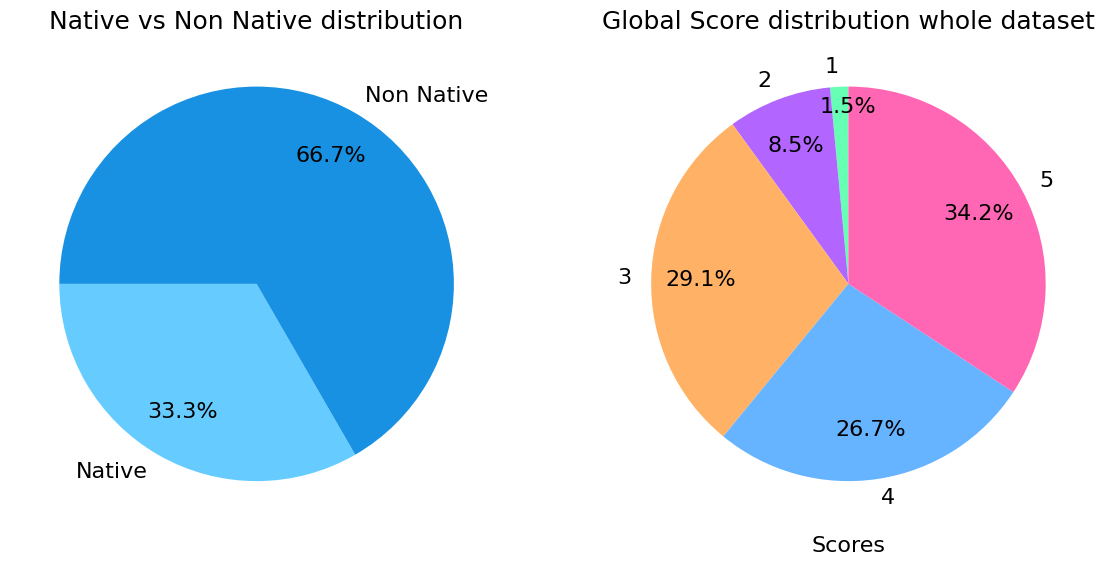

<Figure size 1000x600 with 0 Axes>

In [96]:
# PLot the score distribution
import matplotlib.pyplot as plt

custom_colors = ['#66ffb3', '#b366ff', '#ffb266', '#66b3ff', '#ff66b3']
# custom_colors = ['#ff66b3', '#66b3ff', '#ffb266', '#b366ff', '#66ffb3']


native_percent = int(calculate_percentage(len(native), len(df_no_dup)))
non_native_percent = int(calculate_percentage(len(non_native), len(df_no_dup)))
percentages = [native_percent, non_native_percent]  # Example values
labels_percent = ['Native', 'Non Native']

global_scores = df_no_dup['Score'].value_counts().sort_index()

colors = ['#66CCFF', '#1891E3']


def my_autopct(pct):
    return '{:.1f}%'.format(pct)

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
# Plot of pie plot in subplot was optimized by ChatGPT
axs[0].pie(
    percentages,
    labels=labels_percent,
    colors=colors,
    autopct='%1.1f%%',
    startangle=180,
    pctdistance=0.75, # adjust the position of the percentage labels
    labeldistance=1.1 # adjust the position of the labels
)
axs[0].set_title('Native vs Non Native distribution', fontsize=18)

# Plot as a pie chart
plt.figure(figsize=(10, 6))
global_scores.plot.pie(
    # autopct='',#'%1.1f%%', 
    autopct=my_autopct,
    startangle=90, 
    colors=custom_colors, 
    pctdistance=0.75, # position of the percentage labels
    labeldistance=1.1, # position of the labels
    ax=axs[1],    
)
axs[1].set_title('Global Score distribution whole dataset', fontsize=18)
axs[1].set_xlabel('Scores', fontsize=16)
axs[1].set_ylabel('')

# Set the font size of the labels
for ax in axs:
    for text in ax.texts:
        text.set_fontsize(16)
        # Fix the percentage label that is to smal
        if text.get_text().endswith('1.5%'):
            # text.set_rotation(90) # Rotate the text by 90 degrees

            # Move the precentage text manualy
            text.set_position((text.get_position()[0]+0.03, text.get_position()[1] + 0.15))

plt.tight_layout() 
plt.show()

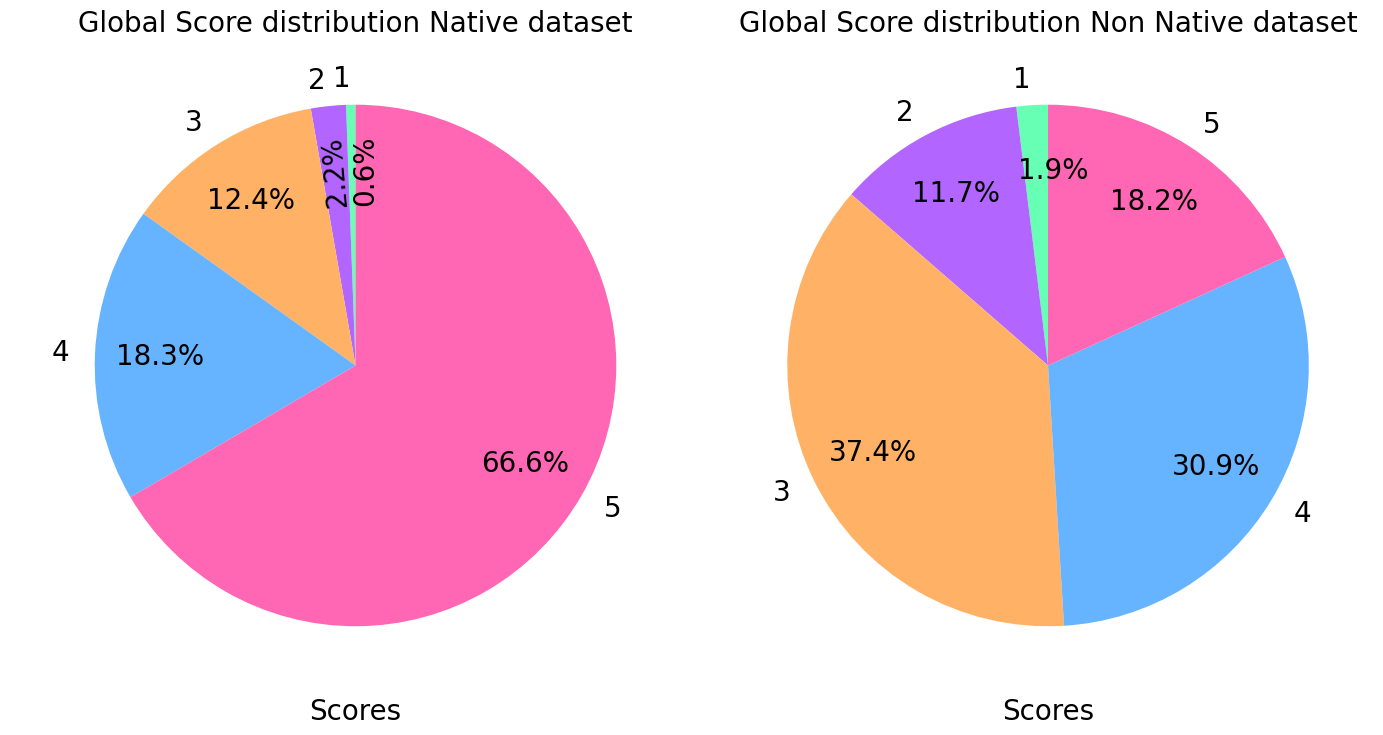

In [112]:
import matplotlib.pyplot as plt
import pandas as pd

custom_colors = ['#66ffb3', '#b366ff', '#ffb266', '#66b3ff', '#ff66b3']
# Count the values of the scores and sort by index to ensure order 1-5
score_native = native['Score'].value_counts().sort_index()
score_non_native = non_native['Score'].value_counts().sort_index()

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Plot for native dataset
score_native.plot.pie(
    autopct='%1.1f%%', 
    startangle=90, 
    colors=custom_colors, 
    pctdistance=0.75,
    labeldistance=1.1,
    ax=axs[0]
)
axs[0].set_title('Global Score distribution Native dataset', fontsize=20)

# Plot for non-native dataset
score_non_native.plot.pie(
    autopct='%1.1f%%', 
    startangle=90, 
    colors=custom_colors, 
    pctdistance=0.75, 
    labeldistance=1.1,
    ax=axs[1]
)
axs[1].set_title('Global Score distribution Non Native dataset', fontsize=20)
axs[0].set_facecolor('#b366ff')

for i in range(2):
    axs[i].set_ylabel(' ')
    axs[i].set_xlabel('Scores', fontsize=20)

# Adjust font sizes for all texts in both subplots
for ax in axs:
    for text in ax.texts:
        text.set_fontsize(20)
        # Adjust position for specific percentage label
        if text.get_text().endswith('1.9%'):
            # text.set_rotation(90)
            text.set_position((text.get_position()[0]+0.065, text.get_position()[1]))
        if text.get_text().endswith('0.6%'):
            text.set_rotation(90)
            text.set_position((text.get_position()[0] + 0.05, text.get_position()[1]))
        if text.get_text().endswith('2.2%'):
            text.set_rotation(95)
            text.set_position((text.get_position()[0] -0.001, text.get_position()[1]))

plt.tight_layout()
# plt.axvline(x=-1.25, color='gray', linestyle='--', linewidth=3)
plt.show()

